# A Small Experiment of PU Learning-Proportion Varying

This is to understanding how PU learning works in Multi-Class Outlier Detection cases


### Setup

In [1]:
# This helps when you're loading functions defined in an external script (if the script is updated while the notebook is running)
%load_ext autoreload 
%autoreload 2

import numpy as np
from sklearn.metrics import precision_score, recall_score
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
from matplotlib import rcParams
import seaborn as sns
from sklearn.decomposition import PCA
from math import sqrt
from sklearn.preprocessing import StandardScaler
import copy

import sys
sys.path.append("..")

from mypackage.data_models import generate_data_uniform_plus_normal 
from mypackage.PUL import compute_pu_scores, compute_pu_scores_intersection_two_step, combine_proportions,calculate_proportions_within_predictions

### Data Generation

In [2]:
# Parameters
n = 20  # Number of iterations

# Generate data
K = 2
dim = 50
means = [1, -1]
radius=4
a_signal=8

# Training data
n_in_train = 2000

# Calibration data
n_in_cal = 2000

# Test data
n_test = 1000

# proportion
prop_in_1_train = [0.01, 0.05, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 0.95, 0.99]
prop_in_1_cal = [0.5]
prop_in_1_test = [0.5, 0.95, 0.99]  # means num of type I inliers in all inliers
prop_outliers = 0.1 # means num of outliers in all test data
# Adjusted proportion combinations
proportion_combinations  = combine_proportions(prop_in_1_train, prop_in_1_cal, prop_in_1_test, prop_outliers)

### Machine Learning Classifier

In [3]:
# Define machine learning models
from sklearn.svm import SVC, OneClassSVM
from sklearn.ensemble import RandomForestClassifier

binary_classifier = SVC(C=1, probability=True)
oneclass_classifier = OneClassSVM(gamma='auto')

### PU Learning

In [4]:
# Run the PU learning procedure for each combination of proportions
all_proportions = {}
for props in proportion_combinations:   
    p1_in_train, p2_in_train, p1_in_cal, p2_in_cal, p1_in_test, p2_in_test, p_outliers = props

    n_in_1_train = int(p1_in_train * n_in_train)
    n_in_2_train = int(p2_in_train * n_in_train)
    n_in_train_values = [n_in_1_train, n_in_2_train]

    for i in range(n):
        n_in_1_cal = int(p1_in_cal * n_in_cal)
        n_in_2_cal = int(p2_in_cal * n_in_cal)
        n_in_cal_values = (n_in_1_cal, n_in_2_cal)
        
        n_in_1_test = int(p1_in_test * n_test)
        n_in_2_test = int(p2_in_test * n_test)
        n_in_test_values = [n_in_1_test, n_in_2_test]

        n_out_test = int(p_outliers * n_test)

        
        # Data Generation
        X_train, Y_train = generate_data_uniform_plus_normal(K, n_in_train_values, 0, dim=dim, means = means, radius=radius, a_signal=a_signal)
        X_cal, Y_cal = generate_data_uniform_plus_normal(K, n_in_cal_values, 0, dim=dim, means = means, radius=radius, a_signal=a_signal)
        X_test_part1, Y_test_part1 = generate_data_uniform_plus_normal(K, n_in_test_values, n_out_test, dim=dim, means = means, radius=radius, a_signal=a_signal)
        X_test_part2, Y_test_part2 = generate_data_uniform_plus_normal(K, n_in_test_values, n_out_test, dim=dim, means = means, radius=radius, a_signal=a_signal)

        scores_cal, scores_test = compute_pu_scores_intersection_two_step(K, X_train, Y_train, X_cal, Y_cal, X_test_part1, X_test_part2, binary_classifier, oneclass_classifier)
        
        # Predict outliers: 0 for outlier, 1 for inlier
        outlier_predictions = (scores_test < np.percentile(scores_test, 90)).astype(int)
        
        # Calculate proportions within the predicted outliers
        proportions_within_predictions = calculate_proportions_within_predictions(Y_test_part2, outlier_predictions)

        # Monitor
        print(f"props:{props}")
        print(f"iteration out of n:{i}")
        print(f"proportions_within_predictions:{proportions_within_predictions}")
    
    all_proportions[props] = proportions_within_predictions

props:(0.01, 0.99, 0.5, 0.5, 0.45, 0.45, 0.1)
iteration out of n:0
proportions_within_predictions:{'type_1_inliers': np.float64(1.0), 'type_2_inliers': np.float64(0.0), 'true_outliers': np.float64(0.0)}
props:(0.01, 0.99, 0.5, 0.5, 0.45, 0.45, 0.1)
iteration out of n:1
proportions_within_predictions:{'type_1_inliers': np.float64(1.0), 'type_2_inliers': np.float64(0.0), 'true_outliers': np.float64(0.0)}
props:(0.01, 0.99, 0.5, 0.5, 0.45, 0.45, 0.1)
iteration out of n:2
proportions_within_predictions:{'type_1_inliers': np.float64(1.0), 'type_2_inliers': np.float64(0.0), 'true_outliers': np.float64(0.0)}
props:(0.01, 0.99, 0.5, 0.5, 0.45, 0.45, 0.1)
iteration out of n:3
proportions_within_predictions:{'type_1_inliers': np.float64(1.0), 'type_2_inliers': np.float64(0.0), 'true_outliers': np.float64(0.0)}
props:(0.01, 0.99, 0.5, 0.5, 0.45, 0.45, 0.1)
iteration out of n:4
proportions_within_predictions:{'type_1_inliers': np.float64(1.0), 'type_2_inliers': np.float64(0.0), 'true_outliers': np

### Plot

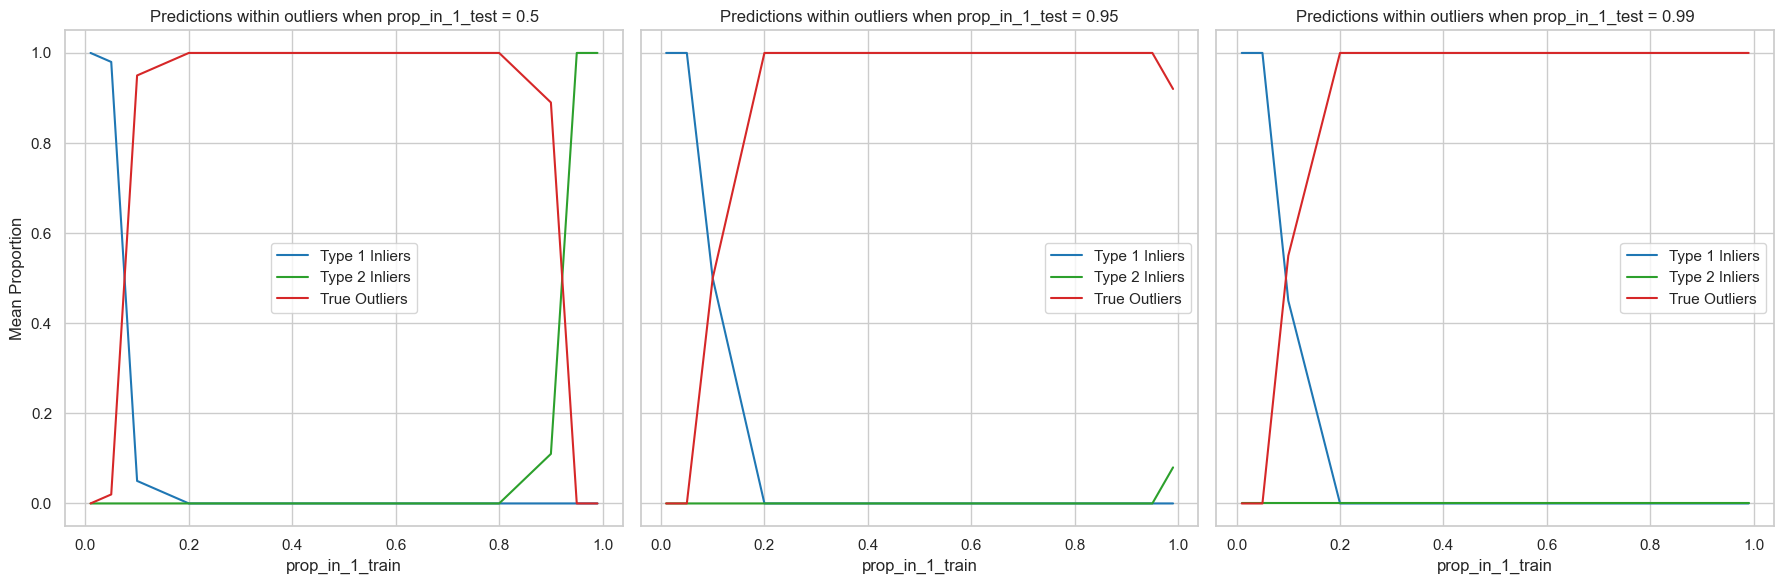

In [5]:
# Define prop_in_1_train and prop_in_1_tests values
prop_in_1_train_values = [0.01, 0.05, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 0.95, 0.99]
prop_in_1_tests = [0.5, 0.95, 0.99]

# Initialize lists to store mean proportions and standard deviations for each prop_in_1_test
mean_type_1_inliers = {test: [] for test in prop_in_1_tests}
mean_type_2_inliers = {test: [] for test in prop_in_1_tests}
mean_true_outliers = {test: [] for test in prop_in_1_tests}

# Calculate mean proportions and standard deviations for each prop_in_1_train and prop_in_1_test
for prop_in_1_train in prop_in_1_train_values:
    for prop_in_1_test in prop_in_1_tests:
        type_1_inliers_values = []
        type_2_inliers_values = []
        true_outliers_values = []
        
        # Collect all values for current prop_in_1_train and prop_in_1_test
        for props, proportions_within_predictions in all_proportions.items():
            if props[0] == prop_in_1_train and props[4] == prop_in_1_test * (1 - props[6]):  # Match prop_in_1_train and prop_in_1_test
                type_1_inliers_values.append(proportions_within_predictions['type_1_inliers'])
                type_2_inliers_values.append(proportions_within_predictions['type_2_inliers'])
                true_outliers_values.append(proportions_within_predictions['true_outliers'])
        
        # Calculate mean
        mean_type_1_inliers[prop_in_1_test].append(np.mean(type_1_inliers_values))
        mean_type_2_inliers[prop_in_1_test].append(np.mean(type_2_inliers_values))
        mean_true_outliers[prop_in_1_test].append(np.mean(true_outliers_values))

# Plotting with Seaborn
sns.set(style="whitegrid")
fig, axs = plt.subplots(1, 3, figsize=(18, 6), sharey=True)

# Iterate through each prop_in_1_test for plotting
for i, prop_in_1_test in enumerate(prop_in_1_tests):
    # Plotting Type 1 Inliers
    sns.lineplot(x=prop_in_1_train_values, y=mean_type_1_inliers[prop_in_1_test], label='Type 1 Inliers', ax=axs[i], color='tab:blue')
    # Plotting Type 2 Inliers
    sns.lineplot(x=prop_in_1_train_values, y=mean_type_2_inliers[prop_in_1_test], label='Type 2 Inliers', ax=axs[i], color='tab:green')
    # Plotting True Outliers
    sns.lineplot(x=prop_in_1_train_values, y=mean_true_outliers[prop_in_1_test], label='True Outliers', ax=axs[i], color='tab:red')
    
    axs[i].set_xlabel('prop_in_1_train')
    axs[i].set_ylabel('Mean Proportion')
    axs[i].set_title(f'Predictions within outliers when prop_in_1_test = {prop_in_1_test}')
    axs[i].legend()

plt.tight_layout()
plt.show()